In [1]:
import requests
import json

#import googlemaps
from itertools import tee

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

%matplotlib inline
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.patches import Rectangle
import math
import re
import os
from requests import get
from urllib.parse import urlparse
import io

from scipy import stats

from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import ConnectionPatch

from sklearn.metrics.pairwise import haversine_distances

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf

import folium
import matplotlib.colors as mcolors

import networkx as nx
pd.set_option('display.float_format', '{:.2f}'.format)

# Load Data

In [2]:
London = gpd.read_file('./github_data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
London_ori = gpd.read_file('./github_data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
commute_time=pd.read_csv('./github_data/travel_time/usual_travel_time.csv')
commute_time_strike=pd.read_csv('./github_data/travel_time/tube_strike_travel_time.csv')
lines = gpd.read_file('./github_data/tfl_lines.json')
commuter_method=pd.read_csv('./github_data/WU03UK_msoa_v3/wu03uk_msoa_v3.csv', 
                         names=['Area of residence', 'Area of workplace','All categories: Method of travel to work',
                               'Work mainly at or from home', 'Underground, metro, light rail, tram', 'Train', 
                               'Bus, minibus or coach', 'Taxi', 'Motorcycle, scooter or moped', 'Driving a car or van',
                               'Passenger in a car or van', 'Bicycle', 'On foot', 'Other method of travel to work'])

bus_stops=pd.read_csv('.\github_data\stops\stops_bus.csv')
tram_stops=pd.read_csv('.\github_data\stops\stops_tram.csv')
tube_stops=pd.read_csv('.\github_data\stops\stops_tube.csv')
rail_stations=pd.read_csv('./github_data/rail_stops.csv')
stops=pd.read_csv('./github_data/stops.csv')

inner_outer_London=gpd.read_file('./github_data/lp-falp-2006-inner-outer-london-shp/lp-falp-2006-inner-outer-london.shp')
central_london=gpd.read_file('./github_data/lp-falp-2006-central-activities-zone-shp/lp-falp-2006-central-activities-zone.shp')

# Data Process

## London Borough

In [3]:
London_MSOA_cent=London.copy()
London=London.to_crs(epsg=4326)
London_MSOA=London.loc[:,['MSOA11CD', 'MSOA11NM']]
London_MSOA_list=list(London_MSOA['MSOA11CD'])
London['centre']=London.to_crs('+proj=cea').centroid.to_crs(epsg=4326)
London['centre_lat'] = London.centre.apply(lambda p: p.y)
London['centre_lon'] = London.centre.apply(lambda p: p.x)
London.head()

MSOA11CD                  MSOA11NM    LAD11CD               LAD11NM  \
0  E02000001        City of London 001  E09000001        City of London   
1  E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2  E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   
3  E02000004  Barking and Dagenham 003  E09000002  Barking and Dagenham   
4  E02000005  Barking and Dagenham 004  E09000002  Barking and Dagenham   

     RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  \
0  E12000007  London      7375      7187        188   25.50    4385   
1  E12000007  London      6775      6724         51   31.30    2713   
2  E12000007  London     10045     10033         12   46.90    3834   
3  E12000007  London      6182      5937        245   24.80    2318   
4  E12000007  London      8562      8562          0   72.10    3183   

   AVHHOLDSZ                                           geometry  \
0       1.60  MULTIPOLYGON (((-0.10414 51.50841, -0.10444 51...   
1       2.50  POLYGON ((0.14809 51.59678, 0.14806 51.59640, ...   
2       2.60  POLYGON ((0.15063 51.58306, 0.14838 51.58075, ...   
3       2.60  POLYGON ((0.18508 51.56480, 0.18400 51.56391, ...   
4       2.70  POLYGON ((0.14988 51.56807, 0.15076 51.56778, ...   

                      centre  centre_lat  centre_lon  
0  POINT (-0.09213 51.51482)       51.51       -0.09  
1   POINT (0.13947 51.58827)       51.59        0.14  
2   POINT (0.14090 51.57492)       51.57        0.14  
3   POINT (0.17683 51.55548)       51.56        0.18  
4   POINT (0.14332 51.56142)       51.56        0.14

In [4]:
boroughs = gpd.read_file('./github_data/Boroughs.gpkg')
boroughs = boroughs.to_crs(epsg=4326)

In [5]:
# 伦敦的经纬度
london_coordinates = (51.5074, -0.1278)

# 创建Folium地图对象
map = folium.Map(location=london_coordinates, tiles='CartoDBPositron', zoom_start=10, control_scale=True)

# generate N visually distinct colours
colors=['grey', 'rosybrown', 'orangered', 'yellow', 'lawngreen', 'deepslyblue', 'blueviolet', 'red', 'orange', 'gold', 'forestgreen', 'royalblue', 'slateblue', 'crimson',
        'brown', 'chocolate', 'limegreen', 'lightskyblue', 'purple', 'firebrick', 'darkorange', 'chartreuse', 'dodgerblue', 'indigo', 'tomato', 'sienna', 'darkolivegreen',
        'steelblue', 'rebeccapurple', 'deeppink', 'indianred', 'saddlebrown', 'midnightblue']

def style_function(i):
    return lambda feature: {
        'fillColor': colors[i],  # Cycle through colors
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.3,
        # "dashArray": "5,10"  # This will make the borders dashed.
    }

for i in range(0, boroughs.shape[0]):
    folium.GeoJson(
        boroughs.iloc[[i],:],
        style_function=style_function(i),
        tooltip=folium.GeoJsonTooltip(fields=['NAME'], labels=True, sticky=False)
    ).add_to(map)


map

### Central, Inner and Outer London

In [6]:
central_london=central_london.to_crs(epsg=4326)

inner_london=inner_outer_London.iloc[[0],:]
inner_london=inner_london.to_crs(epsg=4326)
inner_london = gpd.overlay(inner_london, central_london, how='difference')

outer_london=inner_outer_London.iloc[[1],:]
outer_london=outer_london.to_crs(epsg=4326)

In [7]:
# 创建Folium地图对象
map = folium.Map(location=london_coordinates, tiles='CartoDBPositron', zoom_start=10, control_scale=True)

# central_london_style_function = lambda x: {'fillColor': '#f9ddae', 'color': '#f9ddae'}
# inner_london_style_function = lambda x: {'fillColor': '#eaae8f', 'color': '#eaae8f'}
# outer_london_style_function = lambda x: {'fillColor': '#db9378', 'color': '#db9378'}

folium.GeoJson(central_london.to_json(),
    style_function=lambda feature: {
        'fillColor': 'violet',  # 红色系，你可以根据需要更改颜色
        'color': 'none',
        'weight': 2,
        'fillOpacity': 0.3,
        'dashArray': '5, 5'
    }).add_to(map)
folium.GeoJson(inner_london.to_json(),
    style_function=lambda feature: {
        'fillColor': 'lightskyblue',  # 红色系，你可以根据需要更改颜色
        'color': 'white',
        'weight': 1,
        'fillOpacity': 0.3,
        # 'dashArray': '5, 5'
    }).add_to(map)
folium.GeoJson(outer_london.to_json(),
    style_function=lambda feature: {
        'fillColor': 'orangered',  # 红色系，你可以根据需要更改颜色
        'color': 'white',
        'weight': 1,
        'fillOpacity': 0.3,
        # 'dashArray': '5, 5'
    }).add_to(map)
# 展示地图
map

In [8]:
central_london_bro = gpd.overlay( London, central_london,how='intersection')
central_london_bro=list(central_london_bro['MSOA11CD'])

inner_london_bro = gpd.overlay( London, inner_london,how='intersection')
inner_london_bro=list(inner_london_bro['MSOA11CD'])

outer_london_bro = gpd.overlay( London, outer_london,how='intersection')
outer_london_bro=list(outer_london_bro['MSOA11CD'])

## Public Transport Information

### Lines

In [9]:
lines['mode']=lines['lines']
for i in range(0, lines.shape[0]):
    lines_dict=json.loads(lines.iloc[i,1])
    lines.loc[i,'mode']=lines_dict[0]['name']


tube=['Bakerloo', 'Central', 'Circle', 'District', 'Hammersmith & City', 'Jubilee', 'Metropolitan', 'Northern', 'Piccadilly', 'Victoria', 'Waterloo & City']
lines_tube=lines[lines['mode'].isin(tube)]
lines_tube = lines_tube.to_crs(epsg=4326)
clipped_London_tube = gpd.overlay(lines_tube, London, how='intersection')

lines_rail=lines[~(lines['mode'].isin(tube))]
lines_rail = lines_rail.to_crs(epsg=4326)
clipped_London_rail = gpd.overlay(lines_rail, London, how='intersection')

### Stations

In [10]:
bus_stops=bus_stops.loc[:,['stop_id', 'MSOA11CD', 'MSOA11NM']]
bus_stops=pd.merge(bus_stops, stops, on='stop_id', how='left')
bus_stops=gpd.GeoDataFrame(bus_stops, geometry=gpd.points_from_xy(bus_stops.stop_lon, bus_stops.stop_lat))

tram_stops=tram_stops.loc[:,['stop_id', 'MSOA11CD', 'MSOA11NM']]
tram_stops=pd.merge(tram_stops, stops, on='stop_id', how='left')
tram_stops=gpd.GeoDataFrame(tram_stops, geometry=gpd.points_from_xy(tram_stops.stop_lon, tram_stops.stop_lat))
tram_stops=tram_stops.drop_duplicates(subset='stop_name')
tram_stops.reset_index(drop=True)

tube_stops=tube_stops.loc[:,['stop_id', 'MSOA11CD', 'MSOA11NM']]
tube_stops=pd.merge(tube_stops, stops, on='stop_id', how='left')
tube_stops=gpd.GeoDataFrame(tube_stops, geometry=gpd.points_from_xy(tube_stops.stop_lon, tube_stops.stop_lat))
tube_stops=tube_stops.drop_duplicates(subset='stop_name')

rail_stations = gpd.GeoDataFrame(rail_stations, geometry=gpd.points_from_xy(rail_stations.stop_lon, rail_stations.stop_lat))
rail_stations = rail_stations.set_crs(epsg=4326)
London_ori=London_ori.to_crs(epsg=4326)

In [11]:
rail_stations_london = gpd.sjoin(rail_stations, London_ori, how='right', predicate ='within')
rail_stations_london=rail_stations_london[~(rail_stations_london['stop_name'].isna())]
rail_stations_london=rail_stations_london.reset_index(drop=False)
rail_stations_london=rail_stations_london.loc[:,['stop_name', 'stop_lat', 'stop_lon', 'MSOA11CD']]
rail_stations_london=gpd.GeoDataFrame(rail_stations_london, geometry=gpd.points_from_xy(rail_stations_london.stop_lon, rail_stations_london.stop_lat))
rail_stations_london=rail_stations_london.set_crs(epsg=4326)
rail_stations_london=rail_stations_london.to_crs(epsg=27700)
rail_stations_london.head()

stop_name  stop_lat  stop_lon   MSOA11CD  \
0       London Blackfriars Rail Station     51.51     -0.10  E02000001   
1          City Thameslink Rail Station     51.51     -0.10  E02000001   
2                     Tower Gateway DLR     51.51     -0.07  E02000001   
3     London Cannon Street Rail Station     51.51     -0.09  E02000001   
4  London Fenchurch Street Rail Station     51.51     -0.08  E02000001   

                        geometry  
0  POINT (531714.136 180914.222)  
1  POINT (531689.986 181149.505)  
2  POINT (533771.059 180835.213)  
3  POINT (532600.957 180829.343)  
4  POINT (533472.038 180922.251)

In [12]:
tram_stops = tram_stops.set_crs("EPSG:4326")
tram_stops = tram_stops.to_crs(epsg=27700)

bus_stops = bus_stops.set_crs("EPSG:4326")
bus_stops = bus_stops.to_crs(epsg=27700)

tube_stops = tube_stops.set_crs("EPSG:4326")
tube_stops = tube_stops.to_crs(epsg=27700)

## Commute Information

### Commute time

In [13]:
commute_time=commute_time.rename(columns={'from_id':'Origin_MSOACD',
                                         'to_id':'Destination_MSOACD'})
commute_time = pd.merge(commute_time, London_MSOA, left_on=['Origin_MSOACD'], right_on=['MSOA11CD'])
commute_time=commute_time.rename(columns={'MSOA11NM':'Origin_MSOANM'})
commute_time=commute_time.drop(['MSOA11CD'], axis=1)
commute_time = pd.merge(commute_time, London_MSOA, left_on=['Destination_MSOACD'], right_on=['MSOA11CD'])
commute_time=commute_time.rename(columns={'MSOA11NM':'Destination_MSOANM'})
commute_time=commute_time.drop(['MSOA11CD'], axis=1)

order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM', 'travel_time_p50']
commute_time=commute_time[order]

commute_time=commute_time[commute_time['Origin_MSOACD']!=commute_time['Destination_MSOACD']]

commute_time.head()

Origin_MSOACD             Origin_MSOANM Destination_MSOACD  \
1     E02000002  Barking and Dagenham 001          E02000001   
2     E02000003  Barking and Dagenham 002          E02000001   
3     E02000004  Barking and Dagenham 003          E02000001   
4     E02000005  Barking and Dagenham 004          E02000001   
5     E02000007  Barking and Dagenham 006          E02000001   

   Destination_MSOANM  travel_time_p50  
1  City of London 001            69.00  
2  City of London 001            56.00  
3  City of London 001            65.00  
4  City of London 001            59.00  
5  City of London 001            60.00

In [14]:
commute_time_strike=commute_time_strike.rename(columns={'from_id':'Origin_MSOACD',
                                         'to_id':'Destination_MSOACD'})
commute_time_strike = pd.merge(commute_time_strike, London_MSOA, left_on=['Origin_MSOACD'], right_on=['MSOA11CD'])
commute_time_strike=commute_time_strike.rename(columns={'MSOA11NM':'Origin_MSOANM'})
commute_time_strike=commute_time_strike.drop(['MSOA11CD'], axis=1)
commute_time_strike = pd.merge(commute_time_strike, London_MSOA, left_on=['Destination_MSOACD'], right_on=['MSOA11CD'])
commute_time_strike=commute_time_strike.rename(columns={'MSOA11NM':'Destination_MSOANM'})
commute_time_strike=commute_time_strike.drop(['MSOA11CD'], axis=1)

order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM', 'travel_time_p50']
commute_time_strike=commute_time_strike[order]
commute_time_strike.head()

Origin_MSOACD             Origin_MSOANM Destination_MSOACD  \
0     E02000001        City of London 001          E02000001   
1     E02000002  Barking and Dagenham 001          E02000001   
2     E02000003  Barking and Dagenham 002          E02000001   
3     E02000004  Barking and Dagenham 003          E02000001   
4     E02000005  Barking and Dagenham 004          E02000001   

   Destination_MSOANM  travel_time_p50  
0  City of London 001             0.00  
1  City of London 001            76.00  
2  City of London 001            59.00  
3  City of London 001            68.00  
4  City of London 001            62.00

In [15]:
commute_time=commute_time.rename(columns={'travel_time_p50':'commute_time_usual'})
commute_time_strike=commute_time_strike.rename(columns={'travel_time_p50':'commute_time_strike'})
#commute_time_strike_tram=commute_time_strike_tram.rename(columns={'travel_time_p50':'commute_time_strike_tram'})
commute_time = commute_time.merge(commute_time_strike, on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'])

commute_time['commute_time_difference']=commute_time['commute_time_strike']-commute_time['commute_time_usual']
commute_time.head()

Origin_MSOACD             Origin_MSOANM Destination_MSOACD  \
0     E02000002  Barking and Dagenham 001          E02000001   
1     E02000003  Barking and Dagenham 002          E02000001   
2     E02000004  Barking and Dagenham 003          E02000001   
3     E02000005  Barking and Dagenham 004          E02000001   
4     E02000007  Barking and Dagenham 006          E02000001   

   Destination_MSOANM  commute_time_usual  commute_time_strike  \
0  City of London 001               69.00                76.00   
1  City of London 001               56.00                59.00   
2  City of London 001               65.00                68.00   
3  City of London 001               59.00                62.00   
4  City of London 001               60.00                68.00   

   commute_time_difference  
0                     7.00  
1                     3.00  
2                     3.00  
3                     3.00  
4                     8.00

### Commute method

In [16]:
commuter_method=commuter_method[commuter_method['Area of residence'].isin(list(London['MSOA11CD']))]
commuter_method=commuter_method[commuter_method['Area of workplace'].isin(list(London['MSOA11CD']))].reset_index(drop=True)
commuter_method['Public']=commuter_method['Underground, metro, light rail, tram']+commuter_method['Train']+commuter_method['Bus, minibus or coach']
commuter_method=pd.merge(commuter_method, London_MSOA, left_on='Area of residence', right_on='MSOA11CD')
commuter_method=commuter_method.drop(['MSOA11CD'], axis=1)
commuter_method=commuter_method.rename(columns={'MSOA11NM':'Area of residence NM'})
commuter_method=pd.merge(commuter_method, London_MSOA, left_on='Area of workplace', right_on='MSOA11CD')
commuter_method=commuter_method.rename(columns={'MSOA11NM':'Area of workplace NM'})
commuter_method=commuter_method.drop(['MSOA11CD'], axis=1)
order=['Area of residence', 'Area of residence NM','Area of workplace', 'Area of workplace NM', 
                                'All categories: Method of travel to work', 'Public']
commuter_method=commuter_method[order]
commuter_method=commuter_method[~(commuter_method['Area of residence']==commuter_method['Area of workplace'])]
commuter_method.head()

Area of residence      Area of residence NM Area of workplace  \
1         E02000002  Barking and Dagenham 001         E02000001   
2         E02000003  Barking and Dagenham 002         E02000001   
3         E02000004  Barking and Dagenham 003         E02000001   
4         E02000005  Barking and Dagenham 004         E02000001   
5         E02000007  Barking and Dagenham 006         E02000001   

  Area of workplace NM  All categories: Method of travel to work  Public  
1   City of London 001                                        74      65  
2   City of London 001                                       212     197  
3   City of London 001                                       158     145  
4   City of London 001                                       117      92  
5   City of London 001                                       103      91

<Axes: >

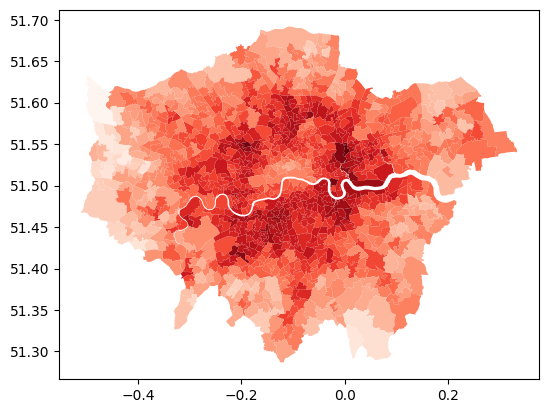

In [17]:
commuter_msoa=commuter_method.groupby(by='Area of residence').sum()
commuter_msoa=commuter_msoa.reset_index()
commuter_msoa['precentage_transport']=commuter_msoa['Public']/commuter_msoa['All categories: Method of travel to work']
commuter_msoa=commuter_msoa.loc[:,['Area of residence', 'Public', 'precentage_transport']]
commuter_msoa=commuter_msoa.sort_values('Public', ascending=False)
commuter_msoa=pd.merge(London, commuter_msoa,  left_on='MSOA11CD', right_on='Area of residence')

commuter_msoa.plot(column=commuter_msoa['precentage_transport'], legend= False, cmap='Reds', alpha=1)

## Scale bar

In [18]:
A=[-0.09213*np.pi/180.,51.51482*np.pi/180.] #Latitude of interest here 40.7 deg, longitude -74.5
B=[-1.09213*np.pi/180.,51.51482*np.pi/180.] ##Latitude of interest here 40.7 deg, longitude -74.5+1
dx=(6371000)*haversine_distances([A,B])[0,1]

# Anlysis

## Statistical Anlysis

C:\Users\zzhao\AppData\Local\Temp\ipykernel_24664\1544406114.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(commute_time['commute_time_usual'],  kde=False, label='normal condition')
C:\Users\zzhao\AppData\Local\Temp\ipykernel_24664\1544406114.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp

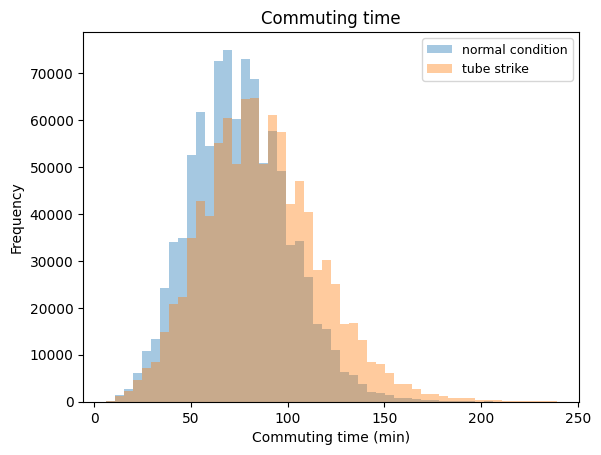

In [19]:
sns.distplot(commute_time['commute_time_usual'],  kde=False, label='normal condition')

sns.distplot(commute_time['commute_time_strike'],  kde=False,label='tube strike')

# Plot formatting
plt.legend(prop={'size': 9})
plt.title('Commuting time')
plt.xlabel('Commuting time (min)')
plt.ylabel('Frequency')
plt.show()

In [20]:
commute_rank=commute_time.copy()
commute_rank=commute_rank.sort_values('commute_time_difference', ascending=False)
#commute_rank=commute_rank[commute_rank['commute_time_difference_tube']<0]
commute_rank=commute_rank.reset_index(drop=True)
commute_rank.head()

Origin_MSOACD       Origin_MSOANM Destination_MSOACD Destination_MSOANM  \
0     E02000896  Waltham Forest 002          E02000497     Hillingdon 004   
1     E02000278         Enfield 002          E02000494     Hillingdon 001   
2     E02000277         Enfield 001          E02000495     Hillingdon 002   
3     E02000495      Hillingdon 002          E02000754      Redbridge 004   
4     E02000493        Havering 030          E02000495     Hillingdon 002   

   commute_time_usual  commute_time_strike  commute_time_difference  
0               97.00               239.00                   142.00  
1              110.00               234.00                   124.00  
2              110.00               234.00                   124.00  
3              100.00               224.00                   124.00  
4              114.00               237.00                   123.00

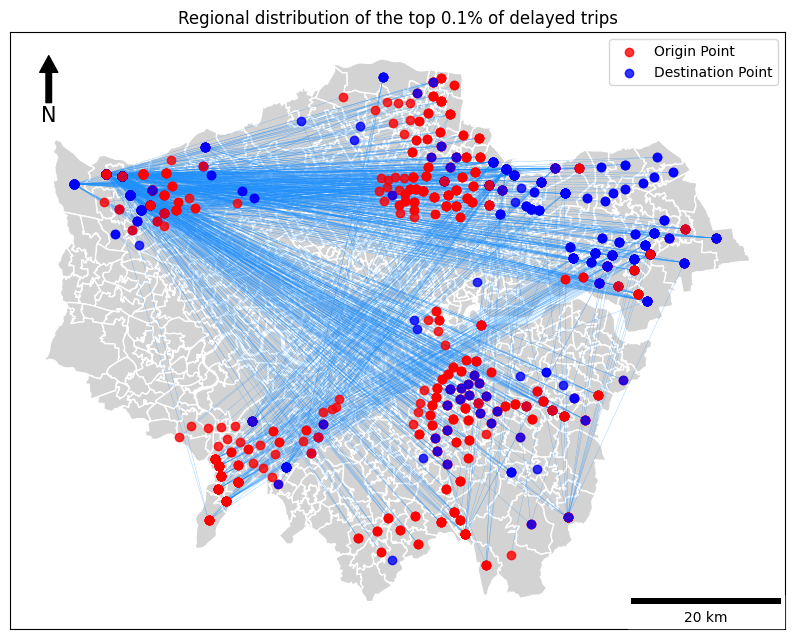

In [21]:
x, y, arrow_length = 0.05, 0.96, 0.1

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
London.plot(ax=ax, facecolor='lightgrey', edgecolor='white')
num = round(commute_rank.shape[0]*0.001)

for i in range(0,num):
    origin_point = London[London['MSOA11CD']==commute_rank.loc[i,'Origin_MSOACD']].reset_index(drop=True).loc[0,'centre'] 
    destination_point = London[London['MSOA11CD']==commute_rank.loc[i,'Destination_MSOACD']].reset_index(drop=True).loc[0,'centre'] 
    
    if i == 0:  # add label only for the first set of points
        ax.scatter(origin_point.x, origin_point.y, alpha=0.8, color='red', zorder=5, label='Origin Point')
        ax.scatter(destination_point.x, destination_point.y, alpha=0.8, color='blue', zorder=5, label='Destination Point')
    else:
        ax.scatter(origin_point.x, origin_point.y, color='red', alpha=0.8, zorder=5)
        ax.scatter(destination_point.x, destination_point.y, alpha=0.8, color='blue', zorder=5)
    
    ax.plot([origin_point.x, destination_point.x], [origin_point.y, destination_point.y], alpha=0.7, color='dodgerblue', linewidth=0.2)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Regional distribution of the top 0.1% of delayed trips')
ax.legend()  # Display legend

ax.add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

plt.show()

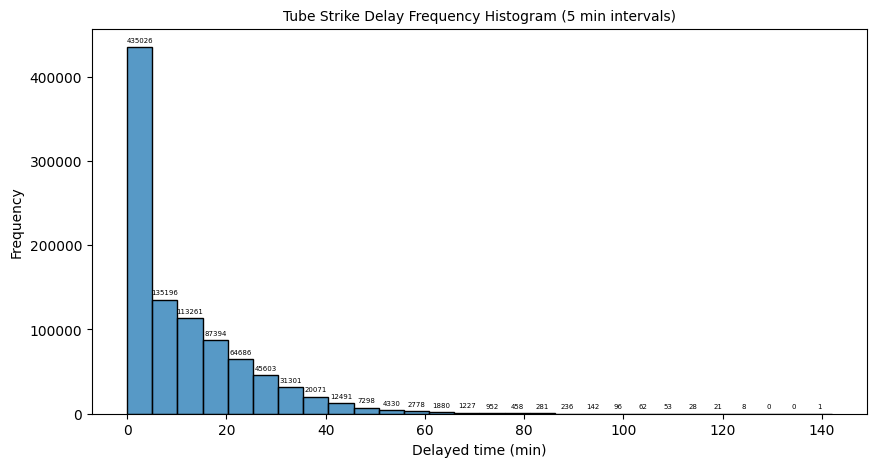

In [22]:
# 生成直方图
fig = plt.subplots(figsize=(10,5))
plot = sns.histplot(data=commute_time, x="commute_time_difference", bins=28)
plot.set_title('Tube Strike Delay Frequency Histogram (5 min intervals)', fontsize=10)
plot.set_xlabel('Delayed time (min)')
plot.set_ylabel('Frequency')

# 在每个柱子上面添加计数
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points',
                   fontsize=5)

plt.show()

## Spatial distribution of delays due to the strike

In [23]:
commute_time_origin=commute_time.groupby(by='Origin_MSOACD').mean('commute_time_difference')
commute_time_origin=commute_time_origin.loc[:,['commute_time_difference']]
commute_time__origin=commute_time_origin.reset_index()
commute_time_destination=commute_time.groupby(by='Destination_MSOACD').mean('commute_time_difference')
commute_time_destination=commute_time_destination.loc[:,['commute_time_difference']]
commute_time_destination=commute_time_destination.reset_index()

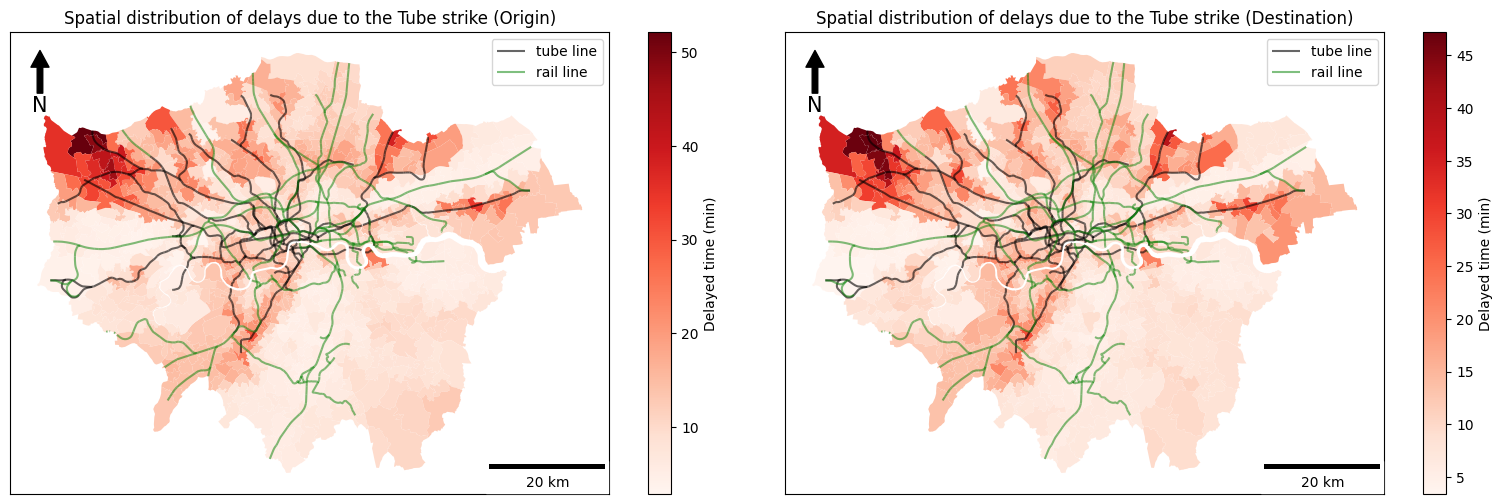

In [24]:
x, y, arrow_length = 0.05, 0.96, 0.12

commute_time_origin_geo=pd.merge(London, commute_time_origin, left_on='MSOA11CD', right_on='Origin_MSOACD')
commute_time_destination_geo=pd.merge(London, commute_time_destination, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
fig.subplots_adjust(wspace = 0.00000001)

commute_time_origin_geo.plot(column=commute_time_origin_geo['commute_time_difference'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0], label='tube line')
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[0], label='rail line')

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].legend()
scale = 1/500000.0 # 米/英寸
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike (Origin)')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time (min)')


commute_time_destination_geo.plot(column=commute_time_destination_geo['commute_time_difference'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1], label='tube line')
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[1], label='rail line')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].legend()
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike (Destination)')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time (min)')

### Percentage

In [25]:
commute_time_percentage=commute_time.copy()
commute_time_percentage['Delay_Time_Precentage']=(commute_time_percentage['commute_time_difference']/commute_time_percentage['commute_time_usual']) * 100

commute_time_percentage_origin=commute_time_percentage.groupby(by='Origin_MSOACD').mean('Delay_Time_Precentage')
commute_time_percentage_origin=commute_time_percentage_origin.loc[:,['Delay_Time_Precentage']]
commute_time_percentage_origin=commute_time_percentage_origin.reset_index(drop=False)

commute_time_percentage_destination=commute_time_percentage.groupby(by='Destination_MSOACD').mean('Delay_Time_Precentage')
commute_time_percentage_destination=commute_time_percentage_destination.loc[:,['Delay_Time_Precentage']]
commute_time_percentage_destination=commute_time_percentage_destination.reset_index(drop=False)

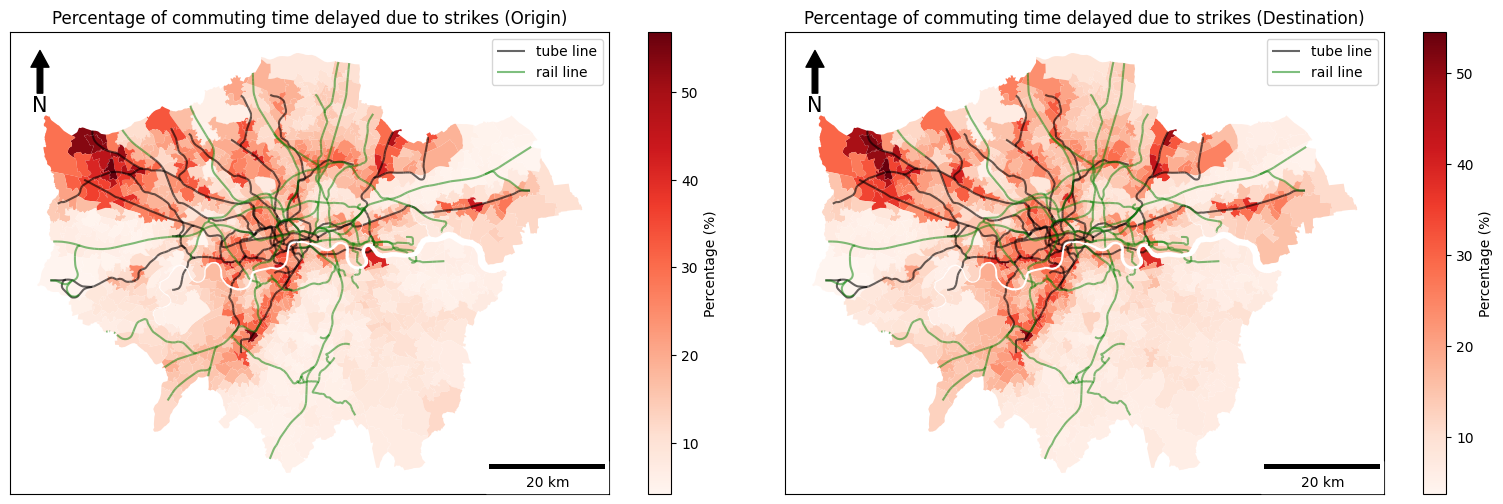

In [26]:
commute_time_percentage_origin_geo=pd.merge(London, commute_time_percentage_origin, left_on='MSOA11CD', right_on='Origin_MSOACD')
commute_time_percentage_destination_geo=pd.merge(London, commute_time_percentage_destination, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
fig.subplots_adjust(wspace = 0.00000001)

commute_time_percentage_origin_geo.plot(column=commute_time_percentage_origin_geo['Delay_Time_Precentage'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0], label='tube line')
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[0], label='rail line')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].legend()
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Percentage of commuting time delayed due to strikes (Origin)')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Percentage (%)')


commute_time_percentage_destination_geo.plot(column=commute_time_percentage_destination_geo['Delay_Time_Precentage'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1], label='tube line')
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[1], label='rail line')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].legend()
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Percentage of commuting time delayed due to strikes (Destination)')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Percentage (%)')

### Consider Commuter Flows

In [27]:
commuter_strike = pd.merge(commute_time, commuter_method, left_on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'], 
                        right_on=['Area of residence', 'Area of residence NM', 'Area of workplace', 'Area of workplace NM'])
commuter_strike=commuter_strike[~(commuter_strike['Destination_MSOACD']==commuter_strike['Origin_MSOACD'])]
commuter_strike['Passenger_commute_difference_total']=commuter_strike['commute_time_difference']*commuter_strike['Public']
order=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM' ,'commute_time_usual', 'commute_time_strike', 'commute_time_difference',
       'Public', 'Passenger_commute_difference_total', 'All categories: Method of travel to work']
commuter_strike=commuter_strike[order]
commuter_strike.head()

Origin_MSOACD             Origin_MSOANM Destination_MSOACD  \
0     E02000002  Barking and Dagenham 001          E02000001   
1     E02000003  Barking and Dagenham 002          E02000001   
2     E02000004  Barking and Dagenham 003          E02000001   
3     E02000005  Barking and Dagenham 004          E02000001   
4     E02000007  Barking and Dagenham 006          E02000001   

   Destination_MSOANM  commute_time_usual  commute_time_strike  \
0  City of London 001               69.00                76.00   
1  City of London 001               56.00                59.00   
2  City of London 001               65.00                68.00   
3  City of London 001               59.00                62.00   
4  City of London 001               60.00                68.00   

   commute_time_difference  Public  Passenger_commute_difference_total  \
0                     7.00      65                              455.00   
1                     3.00     197                              591.00   
2                     3.00     145                              435.00   
3                     3.00      92                              276.00   
4                     8.00      91                              728.00   

   All categories: Method of travel to work  
0                                        74  
1                                       212  
2                                       158  
3                                       117  
4                                       103

In [28]:
commuter_strike.describe()

commute_time_usual  commute_time_strike  commute_time_difference  \
count           351292.00            351288.00                351288.00   
mean                60.28                68.47                     8.20   
std                 21.52                25.28                    10.33   
min                  6.00                 6.00                     0.00   
25%                 45.00                51.00                     0.00   
50%                 58.00                66.00                     4.00   
75%                 73.00                84.00                    13.00   
max                235.00               238.00                   115.00   

         Public  Passenger_commute_difference_total  \
count 351292.00                           351288.00   
mean       4.61                               41.06   
std       17.71                              267.21   
min        0.00                                0.00   
25%        1.00                                0.00   
50%        1.00                                1.00   
75%        3.00                               20.00   
max      979.00                            21035.00   

       All categories: Method of travel to work  
count                                 351292.00  
mean                                       7.97  
std                                       24.62  
min                                        1.00  
25%                                        1.00  
50%                                        2.00  
75%                                        6.00  
max                                     1867.00

In [29]:
commuter_strike['Passenger_commute_usual_total']=commuter_strike['commute_time_usual']*commuter_strike['Public']
time_sum = commuter_strike['Passenger_commute_usual_total'].sum()
passenger_sum=commuter_strike['Public'].sum()
ave_commute_time=time_sum/passenger_sum

tube_strike_sum = commuter_strike['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum

print(f'Average commuting time for London commuters: {ave_commute_time:.2f}')
print(f'Average commuting delays for London commuters: {ave_tube_delay:.2f}')
print(f'Percentage difference in commuting time for London commuters:{ave_tube_delay/ave_commute_time *100:2f}')

Average commuting time for London commuters: 46.43
Average commuting delays for London commuters: 8.90
Percentage difference in commuting time for London commuters:19.176883


#### Visualization

In [30]:
commuter_strike_origin=commuter_strike.groupby(by='Origin_MSOACD').sum()
commuter_strike_origin['average_difference_commute']=commuter_strike_origin['Passenger_commute_difference_total']/commuter_strike_origin['Public']
commuter_strike_origin=commuter_strike_origin.loc[:,['average_difference_commute']]
commuter_strike_origin=commuter_strike_origin.reset_index(drop=False)

commuter_strike_destination=commuter_strike.groupby(by='Destination_MSOACD').sum()
commuter_strike_destination['average_difference_commute']=commuter_strike_destination['Passenger_commute_difference_total']/commuter_strike_destination['Public']
commuter_strike_destination=commuter_strike_destination.loc[:,['average_difference_commute']]
commuter_strike_destination=commuter_strike_destination.reset_index(drop=False)

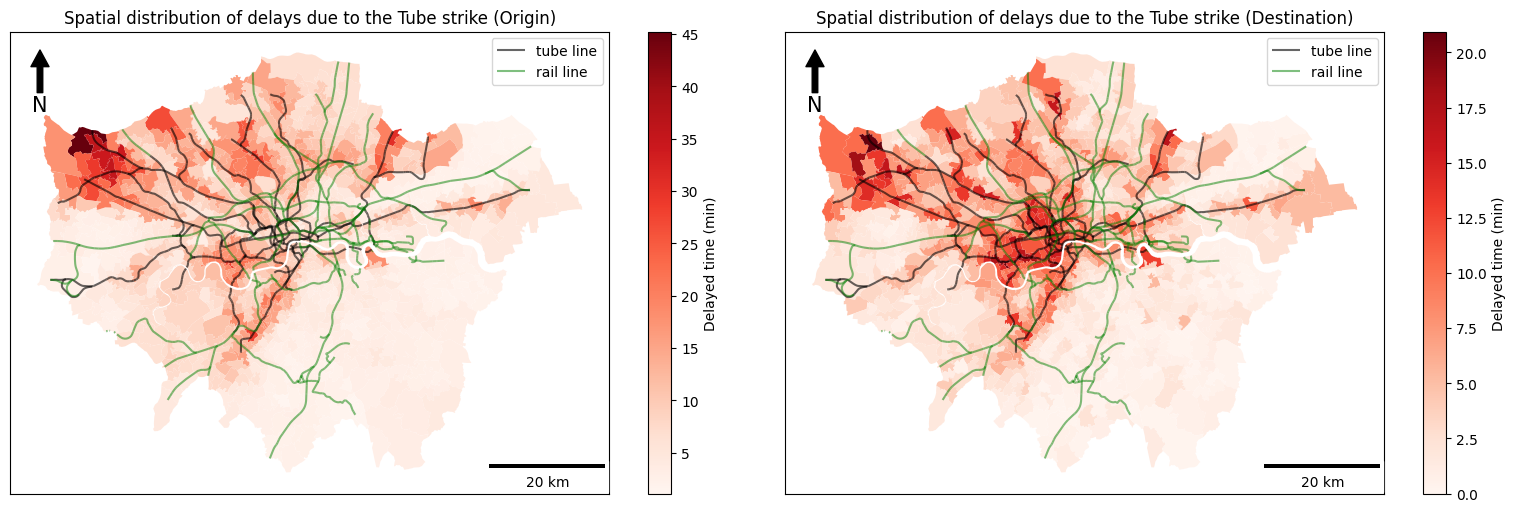

In [31]:
commuter_strike_origin_geo=pd.merge(London, commuter_strike_origin, left_on='MSOA11CD', right_on='Origin_MSOACD')
commuter_strike_destination_geo=pd.merge(London, commuter_strike_destination, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
fig.subplots_adjust(wspace = 0.00000001)

commuter_strike_origin_geo.plot(column=commuter_strike_origin['average_difference_commute'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0], label='tube line')
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[0], label='rail line')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].legend()
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Spatial distribution of delays due to the Tube strike (Origin)')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Delayed time (min)')


commuter_strike_destination_geo.plot(column=commuter_strike_destination_geo['average_difference_commute'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1], label='tube line')
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[1], label='rail line')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].legend()
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Spatial distribution of delays due to the Tube strike (Destination)')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Delayed time (min)')

#### Percentage

In [32]:
commuter_strike_per=commuter_strike.loc[:,['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM',
                                               'commute_time_usual', 'commute_time_strike', 'commute_time_difference', 'Public']]
commuter_strike_per=commuter_strike_per[commuter_strike_per['Origin_MSOACD']!=commuter_strike_per['Destination_MSOACD']]
commuter_strike_per['strike_time_percentage']=(commuter_strike_per['commute_time_difference'] / commuter_strike_per['commute_time_usual'])*100
commuter_strike_per['strike_time_percentage(total_commuters)']=commuter_strike_per['strike_time_percentage'] * commuter_strike_per['Public']

commuter_strike_per_origin=commuter_strike_per.groupby(by='Origin_MSOANM').sum('strike_time_percentage')
commuter_strike_per_origin=commuter_strike_per_origin.reset_index(drop=False)
commuter_strike_per_origin['strike_time_percentage(individuals)']=commuter_strike_per_origin['strike_time_percentage(total_commuters)'] / commuter_strike_per_origin['Public']

commuter_strike_per_destination=commuter_strike_per.groupby(by='Destination_MSOANM').sum('strike_time_percentage')
commuter_strike_per_destination=commuter_strike_per_destination.reset_index(drop=False)
commuter_strike_per_destination['strike_time_percentage(individuals)']=commuter_strike_per_destination['strike_time_percentage(total_commuters)'] / commuter_strike_per_destination['Public']


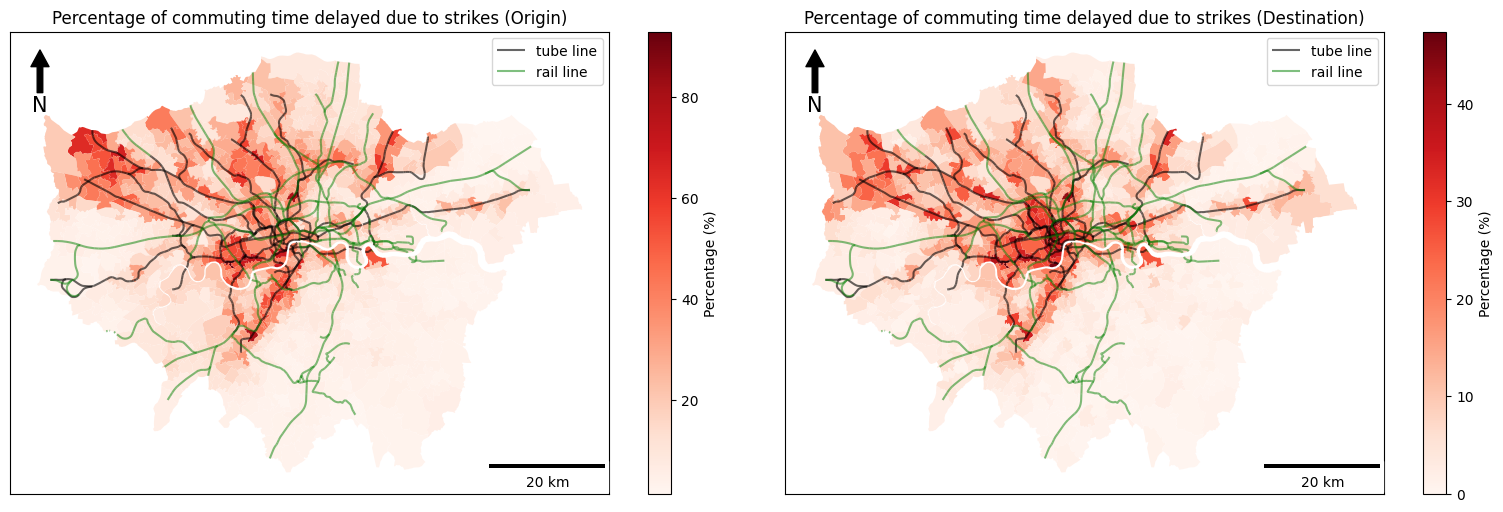

In [33]:
commuter_strike_per_origin_geo=pd.merge(London, commuter_strike_per_origin, left_on='MSOA11NM', right_on='Origin_MSOANM')
commuter_strike_per_destination_geo=pd.merge(London, commuter_strike_per_destination, left_on='MSOA11NM', right_on='Destination_MSOANM')
fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
fig.subplots_adjust(wspace = 0.00000001)

commuter_strike_per_origin_geo.plot(column=commuter_strike_per_origin_geo['strike_time_percentage(individuals)'], legend= False, cmap='Reds', alpha=1, ax=axes[0])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[0], label='tube line')
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[0], label='rail line')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].legend()
axes[0].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[0].set_title('Percentage of commuting time delayed due to strikes (Origin)')
axes[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[0].transAxes)
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Percentage (%)')


commuter_strike_per_destination_geo.plot(column=commuter_strike_per_destination_geo['strike_time_percentage(individuals)'], legend= False, cmap='Reds', ax=axes[1])
clipped_London_tube.plot(color='black', alpha=0.6, ax=axes[1], label='tube line')
clipped_London_rail.plot(color='green', alpha=0.5, ax=axes[1], label='rail line')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].legend()
axes[1].add_artist(ScaleBar(dx=dx, dimension="si-length", units="m", location="lower right"))
axes[1].set_title('Percentage of commuting time delayed due to strikes (Destination)')
axes[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=15,
            xycoords=axes[1].transAxes)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Percentage (%)')

### Three zones

In [34]:
commuter_strike['commute_time_usual_total']=commuter_strike['commute_time_usual']*commuter_strike['Public']

commuter_strike_central_origin=commuter_strike[commuter_strike['Origin_MSOACD'].isin(central_london_bro)]

commuter_strike_cc=commuter_strike_central_origin[commuter_strike_central_origin['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_cc=commuter_strike_cc.reset_index().drop(['index'], axis=1)

commuter_strike_ci=commuter_strike_central_origin[commuter_strike_central_origin['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_ci=commuter_strike_ci.reset_index().drop(['index'], axis=1)

commuter_strike_co=commuter_strike_central_origin[commuter_strike_central_origin['Destination_MSOACD'].isin(outer_london_bro)]
commuter_strike_co=commuter_strike_co.reset_index().drop(['index'], axis=1)

commuter_strike_inner_origin=commuter_strike[commuter_strike['Origin_MSOACD'].isin(inner_london_bro)]

commuter_strike_ic=commuter_strike_inner_origin[commuter_strike_inner_origin['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_ic=commuter_strike_ic.reset_index().drop(['index'], axis=1)

commuter_strike_ii=commuter_strike_inner_origin[commuter_strike_inner_origin['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_ii=commuter_strike_ii.reset_index().drop(['index'], axis=1)

commuter_strike_io=commuter_strike_inner_origin[commuter_strike_inner_origin['Destination_MSOACD'].isin(outer_london_bro)]
commuter_strike_io=commuter_strike_io.reset_index().drop(['index'], axis=1)

commuter_strike_outer_origin=commuter_strike[commuter_strike['Origin_MSOACD'].isin(outer_london_bro)]

commuter_strike_oc=commuter_strike_outer_origin[commuter_strike_outer_origin['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_oc=commuter_strike_oc.reset_index().drop(['index'], axis=1)

commuter_strike_oi=commuter_strike_outer_origin[commuter_strike_outer_origin['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_oi=commuter_strike_oi.reset_index().drop(['index'], axis=1)

commuter_strike_oo=commuter_strike_outer_origin[commuter_strike_outer_origin['Destination_MSOACD'].isin(outer_london_bro)]
commuter_strike_oo=commuter_strike_oo.reset_index().drop(['index'], axis=1)

#### Usual Condition

In [35]:
delay_time_usual_dict={}
delay_time_usual_dict['origin_central']={}
delay_time_usual_dict['origin_inner']={}
delay_time_usual_dict['origin_outer']={}
delay_time_usual_dict['inbound']={}

tube_strike_sum = commuter_strike_cc['commute_time_usual_total'].sum()
passenger_sum=commuter_strike_cc['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_usual_dict['origin_central']['destination_central']=ave_tube_delay

tube_strike_sum = commuter_strike_ci['commute_time_usual_total'].sum()
passenger_sum=commuter_strike_ci['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_usual_dict['origin_central']['destination_inner']=ave_tube_delay

tube_strike_sum = commuter_strike_co['commute_time_usual_total'].sum()
passenger_sum=commuter_strike_co['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_usual_dict['origin_central']['destination_outer']=ave_tube_delay

tube_strike_sum = commuter_strike_ic['commute_time_usual_total'].sum()
passenger_sum=commuter_strike_ic['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_usual_dict['origin_inner']['destination_central']=ave_tube_delay

tube_strike_sum = commuter_strike_ii['commute_time_usual_total'].sum()
passenger_sum=commuter_strike_ii['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_usual_dict['origin_inner']['destination_inner']=ave_tube_delay

tube_strike_sum = commuter_strike_io['commute_time_usual_total'].sum()
passenger_sum=commuter_strike_io['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_usual_dict['origin_inner']['destination_outer']=ave_tube_delay

tube_strike_sum = commuter_strike_oc['commute_time_usual_total'].sum()
passenger_sum=commuter_strike_oc['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_usual_dict['origin_outer']['destination_central']=ave_tube_delay

tube_strike_sum = commuter_strike_oi['commute_time_usual_total'].sum()
passenger_sum=commuter_strike_oi['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_usual_dict['origin_outer']['destination_inner']=ave_tube_delay

tube_strike_sum = commuter_strike_oo['commute_time_usual_total'].sum()
passenger_sum=commuter_strike_oo['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_usual_dict['origin_outer']['destination_outer']=ave_tube_delay

In [36]:
commuter_strike_central_destination=commuter_strike[commuter_strike['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_inner_destination=commuter_strike[commuter_strike['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_outer_destination=commuter_strike[commuter_strike['Destination_MSOACD'].isin(outer_london_bro)]

delay_time_usual_dict['inbound']['destination_central']=commuter_strike_central_destination['commute_time_usual_total'].sum() / commuter_strike_central_destination['Public'].sum()
delay_time_usual_dict['inbound']['destination_inner']=commuter_strike_inner_destination['commute_time_usual_total'].sum() / commuter_strike_inner_destination['Public'].sum()
delay_time_usual_dict['inbound']['destination_outer']=commuter_strike_outer_destination['commute_time_usual_total'].sum() / commuter_strike_outer_destination['Public'].sum()

delay_time_usual_dict['origin_central']['outbound']=commuter_strike_central_origin['commute_time_usual_total'].sum() / commuter_strike_central_origin['Public'].sum()
delay_time_usual_dict['origin_inner']['outbound']=commuter_strike_inner_origin['commute_time_usual_total'].sum() / commuter_strike_inner_origin['Public'].sum()
delay_time_usual_dict['origin_outer']['outbound']=commuter_strike_outer_origin['commute_time_usual_total'].sum() / commuter_strike_outer_origin['Public'].sum()

delay_time_usual_dict['inbound']['outbound']=commuter_strike['commute_time_usual_total'].sum() / commuter_strike['Public'].sum()

In [37]:
commute_time_three = pd.DataFrame(index=['origin_central', 'origin_inner', 'origin_outer', 'inbound'],
                       columns=['destination_central', 'destination_inner', 'destination_outer', 'outbound'])

london_area=['central', 'inner', 'outer']

for i in range(0, commute_time.shape[0]):
    if i<3:
        i=london_area[i]
        origin_area=f'origin_'+i

        for j in london_area:
            destination_area=f'destination_'+j
            commute_time_three.loc[origin_area, destination_area]=round(delay_time_usual_dict[origin_area][destination_area],2)
        
        commute_time_three.loc[origin_area, 'outbound']=round(delay_time_usual_dict[origin_area]['outbound'],2)

    else:
        for j in london_area:
            destination_area=f'destination_'+j
            commute_time_three.loc['inbound', destination_area]=round(delay_time_usual_dict['inbound'][destination_area],2)
        
        commute_time_three.loc['inbound', 'outbound']=round(delay_time_usual_dict['inbound']['outbound'],2)


commute_time_three

destination_central destination_inner destination_outer  \
origin_central               26.63             32.50             51.37   
origin_inner                 38.59             40.66             51.92   
origin_outer                 54.06             53.92             48.16   
inbound                      45.48             46.86             49.32   

               outbound  
origin_central    30.74  
origin_inner      40.83  
origin_outer      52.07  
inbound           46.43

#### Tube Strike

In [38]:
delay_time_dict={}
delay_time_dict['origin_central']={}
delay_time_dict['origin_inner']={}
delay_time_dict['origin_outer']={}
delay_time_dict['inbound']={}

tube_strike_sum = commuter_strike_cc['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike_cc['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_central']['destination_central']=ave_tube_delay

tube_strike_sum = commuter_strike_ci['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike_ci['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_central']['destination_inner']=ave_tube_delay

tube_strike_sum = commuter_strike_co['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike_co['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_central']['destination_outer']=ave_tube_delay

tube_strike_sum = commuter_strike_ic['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike_ic['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_inner']['destination_central']=ave_tube_delay

tube_strike_sum = commuter_strike_ii['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike_ii['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_inner']['destination_inner']=ave_tube_delay

tube_strike_sum = commuter_strike_io['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike_io['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_inner']['destination_outer']=ave_tube_delay

tube_strike_sum = commuter_strike_oc['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike_oc['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_outer']['destination_central']=ave_tube_delay

tube_strike_sum = commuter_strike_oi['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike_oi['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_outer']['destination_inner']=ave_tube_delay

tube_strike_sum = commuter_strike_oo['Passenger_commute_difference_total'].sum()
passenger_sum=commuter_strike_oo['Public'].sum()
ave_tube_delay=tube_strike_sum/passenger_sum
delay_time_dict['origin_outer']['destination_outer']=ave_tube_delay

In [39]:
commuter_strike_central_destination=commuter_strike[commuter_strike['Destination_MSOACD'].isin(central_london_bro)]
commuter_strike_inner_destination=commuter_strike[commuter_strike['Destination_MSOACD'].isin(inner_london_bro)]
commuter_strike_outer_destination=commuter_strike[commuter_strike['Destination_MSOACD'].isin(outer_london_bro)]

delay_time_dict['inbound']['destination_central']=commuter_strike_central_destination['Passenger_commute_difference_total'].sum() / commuter_strike_central_destination['Public'].sum()
delay_time_dict['inbound']['destination_inner']=commuter_strike_inner_destination['Passenger_commute_difference_total'].sum() / commuter_strike_inner_destination['Public'].sum()
delay_time_dict['inbound']['destination_outer']=commuter_strike_outer_destination['Passenger_commute_difference_total'].sum() / commuter_strike_outer_destination['Public'].sum()

delay_time_dict['origin_central']['outbound']=commuter_strike_central_origin['Passenger_commute_difference_total'].sum() / commuter_strike_central_origin['Public'].sum()
delay_time_dict['origin_inner']['outbound']=commuter_strike_inner_origin['Passenger_commute_difference_total'].sum() / commuter_strike_inner_origin['Public'].sum()
delay_time_dict['origin_outer']['outbound']=commuter_strike_outer_origin['Passenger_commute_difference_total'].sum() / commuter_strike_outer_origin['Public'].sum()

delay_time_dict['inbound']['outbound']=commuter_strike['Passenger_commute_difference_total'].sum() / commuter_strike['Public'].sum()

In [40]:
commute_time_strike_three = pd.DataFrame(index=['origin_central', 'origin_inner', 'origin_outer', 'inbound'],
                       columns=['destination_central', 'destination_inner', 'destination_outer', 'outbound'])

london_area=['central', 'inner', 'outer']

for i in range(0, commute_time.shape[0]):
    if i<3:
        i=london_area[i]
        origin_area=f'origin_'+i

        for j in london_area:
            destination_area=f'destination_'+j
            commute_time_strike_three.loc[origin_area, destination_area]=round(delay_time_dict[origin_area][destination_area],2)
        
        commute_time_strike_three.loc[origin_area, 'outbound']=round(delay_time_dict[origin_area]['outbound'],2)

    else:
        for j in london_area:
            destination_area=f'destination_'+j
            commute_time_strike_three.loc['inbound', destination_area]=round(delay_time_dict['inbound'][destination_area],2)
        
        commute_time_strike_three.loc['inbound', 'outbound']=round(delay_time_dict['inbound']['outbound'],2)


commute_time_strike_three

destination_central destination_inner destination_outer  \
origin_central               10.21              9.04              9.61   
origin_inner                 11.35              7.91              6.08   
origin_outer                 10.96              9.10              3.47   
inbound                      11.15              8.66              4.36   

               outbound  
origin_central     9.88  
origin_inner       9.52  
origin_outer       8.24  
inbound            8.90

## Regression

### Datasets

In [41]:
London_MSOA_cent['centre']=London_MSOA_cent.to_crs('+proj=cea').centroid.to_crs(epsg=27700)
London_stations=London_MSOA_cent.copy()
average_distance=London_MSOA_cent.copy()
London_MSOA_station=London_MSOA_cent.copy()

London_MSOA_cent=London_MSOA_cent.loc[:,['MSOA11CD', 'MSOA11NM', 'geometry', 'centre']]
London_MSOA_cent['distance_to_City_of_London'] = London_MSOA_cent.centre.apply(lambda point: point.distance(London_MSOA_cent[London_MSOA_cent['MSOA11CD']=='E02000001'].loc[0,'centre']))
London_MSOA_cent=London_MSOA_cent.loc[:,['MSOA11CD', 'distance_to_City_of_London']]
London_MSOA_cent.head()

MSOA11CD  distance_to_City_of_London
0  E02000001                        0.00
1  E02000002                    18021.23
2  E02000003                    17491.76
3  E02000004                    19200.03
4  E02000005                    17137.02

<Axes: >

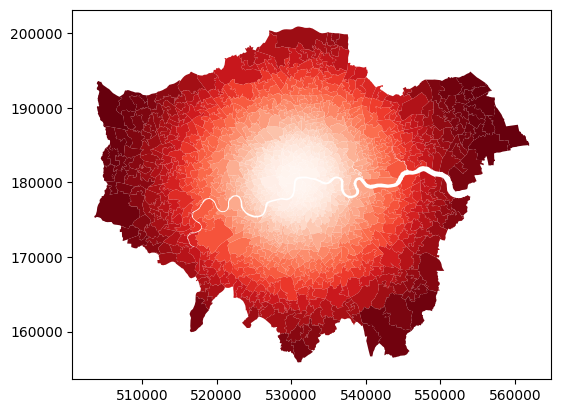

In [42]:
average_distance['average_distance']=average_distance['MSOA11CD']
ave_distance=0

for i in range(0, average_distance.shape[0]):
    point=average_distance.loc[i,'centre']
    distance=average_distance.centre.apply(lambda average_distance: point.distance(average_distance))
    ave_distance=distance.sum()/(average_distance.shape[0]-1)
    average_distance.loc[i, 'average_distance']=ave_distance
    
average_distance.plot(column=average_distance['average_distance'], legend= False, cmap='Reds', alpha=1)

In [43]:
average_distance=average_distance[['MSOA11CD', 'average_distance']]
average_distance['average_distance']=average_distance['average_distance'].astype(float)    
average_distance.head()

C:\Users\zzhao\AppData\Local\Temp\ipykernel_24664\678651706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  average_distance['average_distance']=average_distance['average_distance'].astype(float)


MSOA11CD  average_distance
0  E02000001          12498.11
1  E02000002          22266.95
2  E02000003          21772.98
3  E02000004          23131.02
4  E02000005          21431.59

In [44]:
rail_stations_distance=rail_stations_london.copy()
rail_stations_distance=rail_stations_distance.loc[:,['geometry']]

bus_stations_distance=bus_stops.copy()
bus_stations_distance=bus_stations_distance.loc[:,['geometry']]

tube_stations_distance=tube_stops.copy()
tube_stations_distance=tube_stations_distance.loc[:,['geometry']]

London_MSOA_station['min_distance_to_rail_station']=London_MSOA_station['MSOA11NM']
London_MSOA_station['min_distance_to_tube_station']=London_MSOA_station['MSOA11NM']
London_MSOA_station['min_distance_to_bus_station']=London_MSOA_station['MSOA11NM']

rail_num=0
bus_num=0
tube_num=0
London_MSOA_station['the_no._of_rail_stations_within_1km']=London_MSOA_station['COMESTRES']
London_MSOA_station['the_no._of_bus_stations_within_1km']=London_MSOA_station['COMESTRES']
London_MSOA_station['the_no._of_tube_stations_within_1km']=London_MSOA_station['COMESTRES']

In [45]:
for i in range(0, London_MSOA_station.shape[0]):
    rail_distances = rail_stations_distance.geometry.apply(lambda rail_stations_distance: London_MSOA_station.loc[i,'centre'].distance(rail_stations_distance))
    rail_min_distance = rail_distances.min()
    rail_num=len([j for j in rail_distances if j <= 1000])
    London_MSOA_station.loc[i,'min_distance_to_rail_station']=rail_min_distance
    London_MSOA_station.loc[i, 'the_no._of_rail_stations_within_1km']=rail_num


    bus_distances = bus_stations_distance.geometry.apply(lambda bus_stations_distance: London_MSOA_station.loc[i,'centre'].distance(bus_stations_distance))
    bus_min_distance = bus_distances.min()
    bus_num=len([j for j in bus_distances if j <= 1000])
    London_MSOA_station.loc[i,'min_distance_to_bus_station']=bus_min_distance
    London_MSOA_station.loc[i, 'the_no._of_bus_stations_within_1km']=bus_num

    tube_distances = tube_stations_distance.geometry.apply(lambda tube_stations_distance: London_MSOA_station.loc[i,'centre'].distance(tube_stations_distance))
    tube_min_distance = tube_distances.min()
    tube_num=len([j for j in tube_distances if j <= 1000])
    London_MSOA_station.loc[i,'min_distance_to_tube_station']=tube_min_distance
    London_MSOA_station.loc[i, 'the_no._of_tube_stations_within_1km']=tube_num

London_MSOA_station['min_distance_to_rail_station'] = London_MSOA_station['min_distance_to_rail_station'].astype(float)
London_MSOA_station['min_distance_to_bus_station'] = London_MSOA_station['min_distance_to_bus_station'].astype(float)
London_MSOA_station['min_distance_to_tube_station'] = London_MSOA_station['min_distance_to_tube_station'].astype(float)
London_MSOA_station=London_MSOA_station.loc[:,['MSOA11CD', 'min_distance_to_tube_station', 'min_distance_to_bus_station','min_distance_to_rail_station', 
'the_no._of_tube_stations_within_1km', 'the_no._of_bus_stations_within_1km', 'the_no._of_rail_stations_within_1km']]
London_MSOA_station.head()

MSOA11CD  min_distance_to_tube_station  min_distance_to_bus_station  \
0  E02000001                        392.82                       148.60   
1  E02000002                       3452.78                       223.32   
2  E02000003                       3525.13                        42.27   
3  E02000004                       1491.05                       173.37   
4  E02000005                       2211.85                       118.66   

   min_distance_to_rail_station  the_no._of_tube_stations_within_1km  \
0                        455.52                                    9   
1                       2365.75                                    0   
2                       1127.61                                    0   
3                       1516.98                                    0   
4                       1238.60                                    0   

   the_no._of_bus_stations_within_1km  the_no._of_rail_stations_within_1km  
0                                 103                                    6  
1                                  20                                    0  
2                                  28                                    0  
3                                  17                                    0  
4                                  37                                    0

In [46]:
London_MSOA_station['availability_of_tube_stations_within_1km']=London_MSOA_station['MSOA11CD']

for i in range(0, London_MSOA_station.shape[0]):
    if London_MSOA_station.loc[i, 'the_no._of_tube_stations_within_1km'] == 0:
        London_MSOA_station.loc[i, 'availability_of_tube_stations_within_1km'] = 'no'
    else:
        London_MSOA_station.loc[i, 'availability_of_tube_stations_within_1km'] = 'yes'

London_MSOA_station.head()

MSOA11CD  min_distance_to_tube_station  min_distance_to_bus_station  \
0  E02000001                        392.82                       148.60   
1  E02000002                       3452.78                       223.32   
2  E02000003                       3525.13                        42.27   
3  E02000004                       1491.05                       173.37   
4  E02000005                       2211.85                       118.66   

   min_distance_to_rail_station  the_no._of_tube_stations_within_1km  \
0                        455.52                                    9   
1                       2365.75                                    0   
2                       1127.61                                    0   
3                       1516.98                                    0   
4                       1238.60                                    0   

   the_no._of_bus_stations_within_1km  the_no._of_rail_stations_within_1km  \
0                                 103                                    6   
1                                  20                                    0   
2                                  28                                    0   
3                                  17                                    0   
4                                  37                                    0   

  availability_of_tube_stations_within_1km  
0                                      yes  
1                                       no  
2                                       no  
3                                       no  
4                                       no

In [47]:
London_stations['location_in_London']=London_stations['MSOA11NM']

for i in range(0, London_stations.shape[0]):
    if London_stations.loc[i, 'MSOA11CD'] in central_london_bro:
        London_stations.loc[i,'location_in_London']='central'

    elif London_stations.loc[i, 'MSOA11CD'] in inner_london_bro:
        London_stations.loc[i,'location_in_London']='inner'

    else:
        London_stations.loc[i,'location_in_London']='outer'

London_stations.head()

MSOA11CD                  MSOA11NM    LAD11CD               LAD11NM  \
0  E02000001        City of London 001  E09000001        City of London   
1  E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2  E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   
3  E02000004  Barking and Dagenham 003  E09000002  Barking and Dagenham   
4  E02000005  Barking and Dagenham 004  E09000002  Barking and Dagenham   

     RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  \
0  E12000007  London      7375      7187        188   25.50    4385   
1  E12000007  London      6775      6724         51   31.30    2713   
2  E12000007  London     10045     10033         12   46.90    3834   
3  E12000007  London      6182      5937        245   24.80    2318   
4  E12000007  London      8562      8562          0   72.10    3183   

   AVHHOLDSZ                                           geometry  \
0       1.60  MULTIPOLYGON (((531667.624 180534.992, 531647....   
1       2.50  POLYGON ((548881.563 190845.265, 548881.125 19...   
2       2.60  POLYGON ((549102.438 189324.625, 548954.500 18...   
3       2.60  POLYGON ((551549.998 187364.637, 551478.000 18...   
4       2.70  POLYGON ((549099.634 187656.076, 549161.375 18...   

                          centre location_in_London  
0  POINT (532482.695 181269.246)            central  
1  POINT (548312.943 189881.325)              outer  
2  POINT (548454.945 188400.094)              outer  
3  POINT (551008.970 186310.886)              outer  
4  POINT (548667.092 186903.318)              outer

In [48]:
regression_data=London_stations.loc[:,['MSOA11CD', 'MSOA11NM', 'geometry', 'location_in_London',  'LAD11NM']]
regression_data=pd.merge(regression_data, London_MSOA_cent, left_on='MSOA11CD', right_on='MSOA11CD', how='left')
regression_data=pd.merge(regression_data, London_MSOA_station, left_on='MSOA11CD', right_on='MSOA11CD', how='left')
regression_data=pd.merge(regression_data, average_distance, left_on='MSOA11CD', right_on='MSOA11CD', how='left')
regression_data=pd.merge(regression_data, commute_time_origin, left_on='MSOA11CD', right_on='Origin_MSOACD', how='left')
regression_data=regression_data.loc[:,['commute_time_difference', 'distance_to_City_of_London', 'average_distance', 'the_no._of_tube_stations_within_1km', 'the_no._of_bus_stations_within_1km', 
                                       'the_no._of_rail_stations_within_1km', 'min_distance_to_tube_station', 'min_distance_to_bus_station', 'min_distance_to_rail_station',
                                        'availability_of_tube_stations_within_1km', 'location_in_London','LAD11NM']]
regression_data.head()

commute_time_difference  distance_to_City_of_London  average_distance  \
0                     8.56                        0.00          12498.11   
1                     6.33                    18021.23          22266.95   
2                     4.78                    17491.76          21772.98   
3                     9.98                    19200.03          23131.02   
4                     4.81                    17137.02          21431.59   

   the_no._of_tube_stations_within_1km  the_no._of_bus_stations_within_1km  \
0                                    9                                 103   
1                                    0                                  20   
2                                    0                                  28   
3                                    0                                  17   
4                                    0                                  37   

   the_no._of_rail_stations_within_1km  min_distance_to_tube_station  \
0                                    6                        392.82   
1                                    0                       3452.78   
2                                    0                       3525.13   
3                                    0                       1491.05   
4                                    0                       2211.85   

   min_distance_to_bus_station  min_distance_to_rail_station  \
0                       148.60                        455.52   
1                       223.32                       2365.75   
2                        42.27                       1127.61   
3                       173.37                       1516.98   
4                       118.66                       1238.60   

  availability_of_tube_stations_within_1km location_in_London  \
0                                      yes            central   
1                                       no              outer   
2                                       no              outer   
3                                       no              outer   
4                                       no              outer   

                LAD11NM  
0        City of London  
1  Barking and Dagenham  
2  Barking and Dagenham  
3  Barking and Dagenham  
4  Barking and Dagenham

### OLS regression

In [49]:
London_stations_numeric = pd.get_dummies(regression_data.drop(['location_in_London', 'LAD11NM'], axis=1))
London_stations_numeric = London_stations_numeric.astype({'availability_of_tube_stations_within_1km_no': np.uint8, 
                                                          'availability_of_tube_stations_within_1km_yes': np.uint8})

London_stations_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   commute_time_difference                       983 non-null    float64
 1   distance_to_City_of_London                    983 non-null    float64
 2   average_distance                              983 non-null    float64
 3   the_no._of_tube_stations_within_1km           983 non-null    int64  
 4   the_no._of_bus_stations_within_1km            983 non-null    int64  
 5   the_no._of_rail_stations_within_1km           983 non-null    int64  
 6   min_distance_to_tube_station                  983 non-null    float64
 7   min_distance_to_bus_station                   983 non-null    float64
 8   min_distance_to_rail_station                  983 non-null    float64
 9   availability_of_tube_stations_within_1km_no   983 non-null    uin

In [50]:
London_stations_final = London_stations_numeric.drop(['availability_of_tube_stations_within_1km_no'], axis=1)
London_stations_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 10 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   commute_time_difference                       983 non-null    float64
 1   distance_to_City_of_London                    983 non-null    float64
 2   average_distance                              983 non-null    float64
 3   the_no._of_tube_stations_within_1km           983 non-null    int64  
 4   the_no._of_bus_stations_within_1km            983 non-null    int64  
 5   the_no._of_rail_stations_within_1km           983 non-null    int64  
 6   min_distance_to_tube_station                  983 non-null    float64
 7   min_distance_to_bus_station                   983 non-null    float64
 8   min_distance_to_rail_station                  983 non-null    float64
 9   availability_of_tube_stations_within_1km_yes  983 non-null    uin

Text(0.5, 1.0, 'Correlation Matrix')

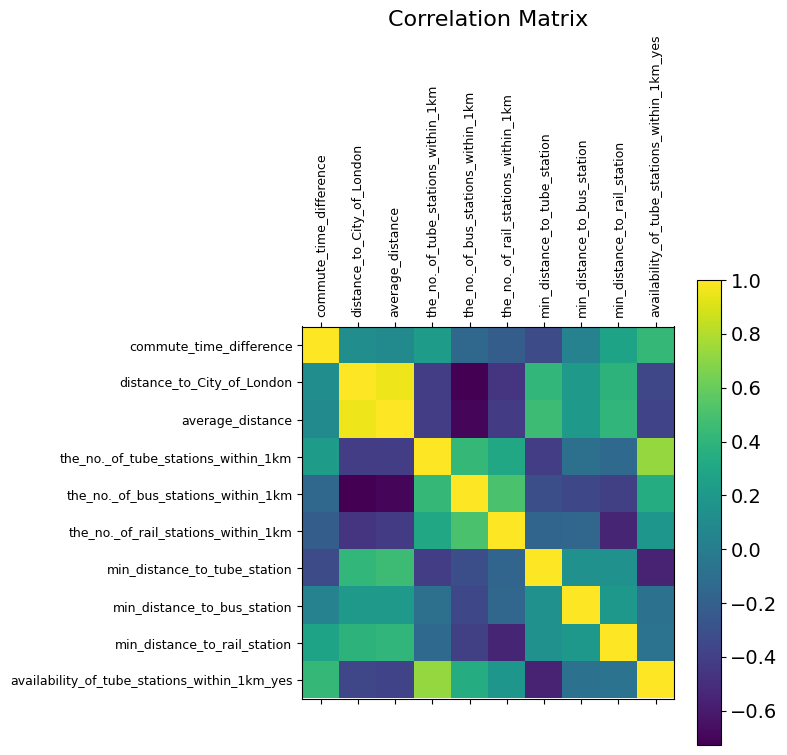

In [51]:
df = London_stations_final
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(6, 6))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=9, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=9)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

#### VIF

In [52]:
def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

#         d = {'a': 1, 'b': 2, 'c': 3}
#  |  >>> ser = pd.Series(data=d, index=['a', 'b', 'c'])
#  |  >>> ser
#  |  a   1
#  |  b   2
#  |  c   3
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame() #  convert the given series object to a dataframe.

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [53]:
London_stations_VIF = drop_column_using_vif_(London_stations_final.drop('commute_time_difference', axis=1))

Dropping: distance_to_City_of_London


#### Results

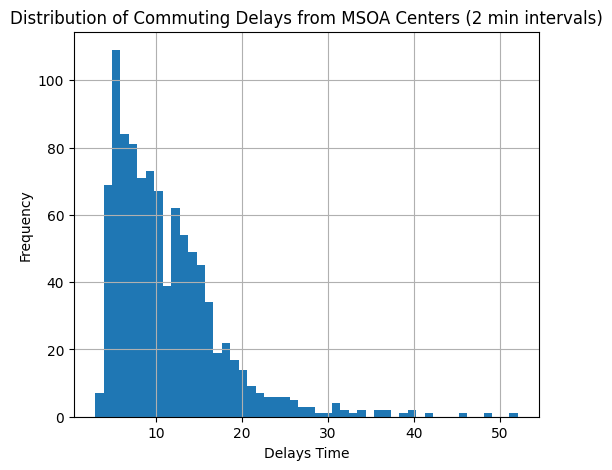

In [54]:
fig, ax = plt.subplots(figsize=(6,5))
London_stations_final['commute_time_difference'].hist(bins=50, ax=ax)
ax.set_xlabel('Delays Time')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Commuting Delays from MSOA Centers (2 min intervals)')
plt.show()

In [55]:
model_commute_time = sm.OLS(endog=regression_data['commute_time_difference'], exog=sm.add_constant(London_stations_VIF.drop([
'min_distance_to_bus_station', 'the_no._of_tube_stations_within_1km', 'average_distance'], axis=1))).fit()
model_commute_time.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     commute_time_difference   R-squared:                       0.354
Model:                                 OLS   Adj. R-squared:                  0.351
Method:                      Least Squares   F-statistic:                     107.2
Date:                     Fri, 25 Aug 2023   Prob (F-statistic):           2.80e-90
Time:                             09:02:08   Log-Likelihood:                -2999.2
No. Observations:                      983   AIC:                             6010.
Df Residuals:                          977   BIC:                             6040.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           13.0746      0.703     18.606      0.000      11.696      14.454
the_no._of_bus_stations_within_1km              -0.0781      0.011     -7.056      0.000      -0.100      -0.056
the_no._of_rail_stations_within_1km             -0.5406      0.153     -3.539      0.000      -0.840      -0.241
min_distance_to_tube_station                    -0.0004   6.19e-05     -6.859      0.000      -0.001      -0.000
min_distance_to_rail_station                     0.0016      0.000      5.718      0.000       0.001       0.002
availability_of_tube_stations_within_1km_yes     5.3777      0.415     12.967      0.000       4.564       6.191
==============================================================================
Omnibus:                      353.112   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2238.133
Skew:                           1.501   Prob(JB):                         0.00
Kurtosis:                       9.755   Cond. No.                     1.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

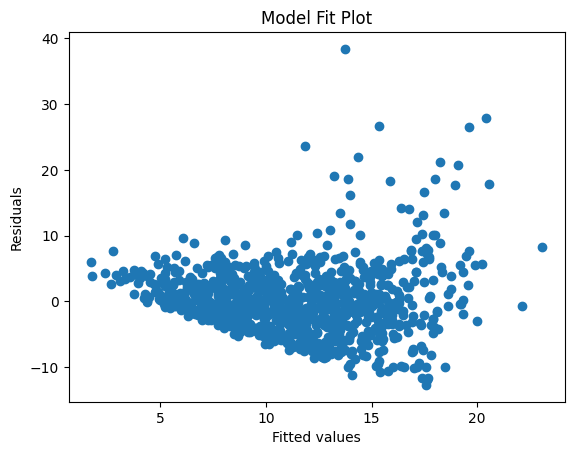

In [56]:
fig, ax = plt.subplots()
plt.scatter(model_commute_time.fittedvalues, model_commute_time.resid)
# ax.scatter(model_commute_time.fittedvalues, model_commute_time.resid)

ax.set_title('Model Fit Plot')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted values')
plt.show()